<a href="https://colab.research.google.com/github/Abhishek-Manish/Deakin_End_Term_Assessment/blob/main/End_Term_Assignment_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1
---

#Environment Setup & Data Loading

In [57]:
# --- Install & Import Dependencies ---
# In Colab, PySpark is not pre-installed, so we install it
!pip install pyspark wordcloud seaborn matplotlib --q

In [58]:

# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, to_date, from_unixtime, hour, dayofweek, countDistinct, avg

# --- Initialize Spark Session ---
spark = SparkSession.builder.appName("BusinessReviewAnalysis").getOrCreate()


In [59]:
# --- Upload & Extract Data (business_review_submission.zip) ---
import zipfile
import os

zip_path = "/content/business_review_submission.zip" # Path to zip file
extract_dir = "/content/review_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Check extracted files
os.listdir(extract_dir)

['meta-review-business.csv', 'review.csv']

---
## Question 1.1
---
#### Answer 1.1.1

In [60]:
# --- Load Review Data into Spark ---
review_df = spark.read.csv(f"{extract_dir}/review.csv", header=True, inferSchema=True)

# Preview schema and data
review_df.printSchema()
review_df.show(5)

root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)

+--------------------+--------------------+-------------+--------------------+--------------------+----+----+--------------------+
|             user_id|                name|         time|              rating|                text|pics|resp|             gmap_id|
+--------------------+--------------------+-------------+--------------------+--------------------+----+----+--------------------+
|1.091298048426862...|          Nicki Gore|1566331951619|                   5|We always stay he...|NULL|NULL|0x56b646ed2220b77...|
|1.132409264057589...|       Allen Ratliff|1504917982385|                   5|Great campground ...|NULL|NULL|0x56b646ed2220b77...|
|1.130448378911412...|   Jonathan Tringali|

In [61]:
# --- Replace null text with 'no review' ---
review_df = review_df.withColumn(
    "text",
    when(col("text").isNull(), "no review").otherwise(col("text"))
)
review_df.select('text').show(10)

+--------------------+
|                text|
+--------------------+
|We always stay he...|
|Great campground ...|
|We tent camped he...|
| but they lack ve...|
|           no review|
|This place is jus...|
|Probably the nice...|
|Great, slept like...|
|It is always a tr...|
|Only 3 booths wit...|
+--------------------+
only showing top 10 rows



### Answer 1.1.2

In [62]:
from pyspark.sql.functions import regexp_extract

# --- Keep only numeric values in 'time' ---
# Extract only digits from time column (ignore text like 'toilet')
review_df = review_df.withColumn("time_clean", regexp_extract(col("time"), "([0-9]+)", 1))

# --- Convert to bigint (milliseconds) ---
review_df = review_df.withColumn("time_clean", col("time_clean").cast("bigint"))

# --- Convert ms → seconds ---
review_df = review_df.withColumn("time_sec", (col("time_clean")/1000).cast("bigint"))

# --- Create newtime column (yyyy-MM-dd) ---
review_df = review_df.withColumn("newtime", to_date(from_unixtime(col("time_sec"))))

review_df.select("time", "newtime").show(10, truncate=False)

+-------------+----------+
|time         |newtime   |
+-------------+----------+
|1566331951619|2019-08-20|
|1504917982385|2017-09-09|
|1474765901185|2016-09-25|
| toilet      |NULL      |
|NULL         |NULL      |
|1472858535682|2016-09-02|
|1529649811341|2018-06-22|
|1466170294782|2016-06-17|
|1625369270215|2021-07-04|
|1629350418882|2021-08-19|
+-------------+----------+
only showing top 10 rows



---
## Question 1.2
---
#### Answer 1.2.1

In [63]:
# --- Count reviews per gmap_id ---
gmap_reviews = review_df.groupBy("gmap_id").count().withColumnRenamed("count", "review_count")

# Cast to float
gmap_reviews = gmap_reviews.withColumn("review_count", col("review_count").cast("float"))

# Show top 5
gmap_reviews.show(5)

+--------------------+------------+
|             gmap_id|review_count|
+--------------------+------------+
|0x56c8977642a793f...|        24.0|
|0x56c79c63a5af15e...|        10.0|
|0x56c8976e16705e6...|        49.0|
|0x51325aac7a4434e...|        28.0|
|0x56c6631e3219094...|        12.0|
+--------------------+------------+
only showing top 5 rows



### Answer 1.2.2

In [64]:
# --- Extract review hour ---
review_df = review_df.withColumn("review_time", hour(from_unixtime(col("time_sec"))))

# Convert to Pandas for visualization
df = review_df.select("gmap_id", "newtime", "review_time").toPandas()

# Show top 5
df.head()

,gmap_id,newtime,review_time
0,0x56b646ed2220b77f:0xd8975e316de80952,2019-08-20,20.0
1,0x56b646ed2220b77f:0xd8975e316de80952,2017-09-09,0.0
2,None,2016-09-25,1.0
3,None,None,NaN
4,None,None,NaN


### Answer 1.2.3

In [65]:
# Drop rows where review_time is null
df_clean = df.dropna(subset=["review_time"])

# Define time-of-day bins
df_clean["time_of_day"] = pd.cut(
    df_clean["review_time"],
    bins=[-1, 11, 17, 23],  # Morning=0–11, Afternoon=12–17, Evening/Night=18–23
    labels=["Morning (0–11)", "Afternoon (12–17)", "Evening/Night (18–23)"]
)

/tmp/ipython-input-1924405808.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["time_of_day"] = pd.cut(


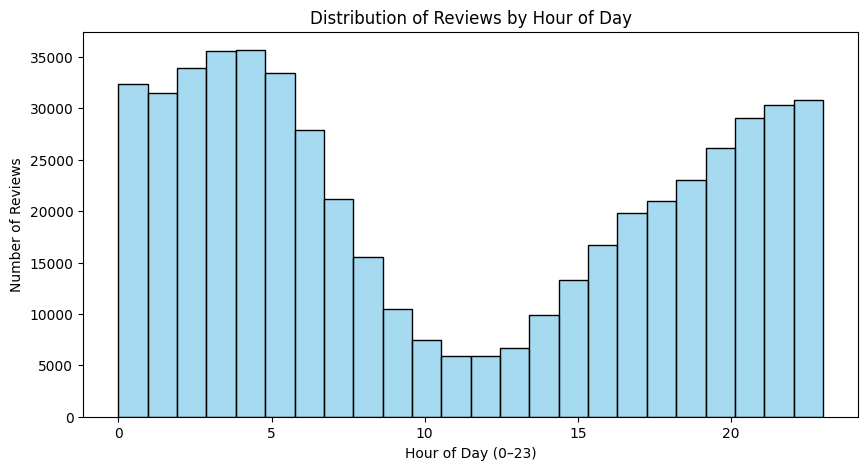

In [66]:

# --- Plot 1: Histogram of Reviews by Hour ---
plt.figure(figsize=(10,5))
sns.histplot(df_clean["review_time"], bins=24, color="skyblue")
plt.title("Distribution of Reviews by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.show();

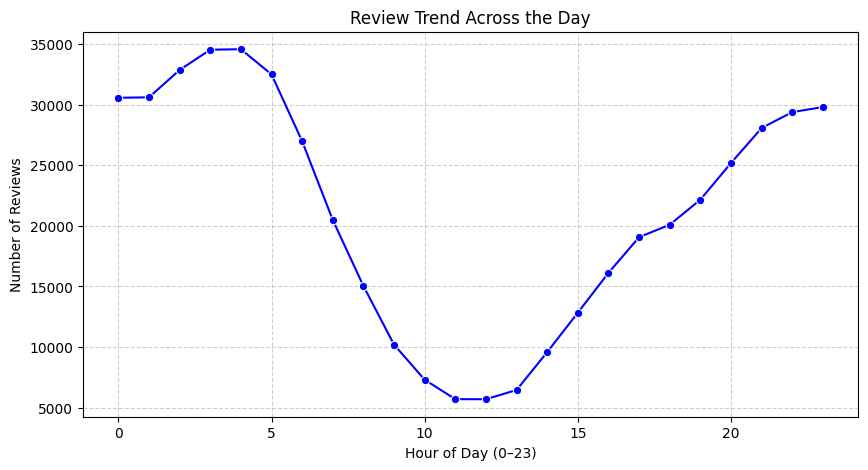

In [67]:
# --- Plot 2: Line Plot of Reviews per Hour ---
reviews_per_hour = df_clean.groupby("review_time")["gmap_id"].count().reset_index(name="num_reviews")
plt.figure(figsize=(10,5))
sns.lineplot(data=reviews_per_hour, x="review_time", y="num_reviews", marker="o", color="blue")
plt.title("Review Trend Across the Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show();

* From the above **Plot 1** and **Plot 2**, we can observed that most of the reviews are recorded during the morning and evening timings.

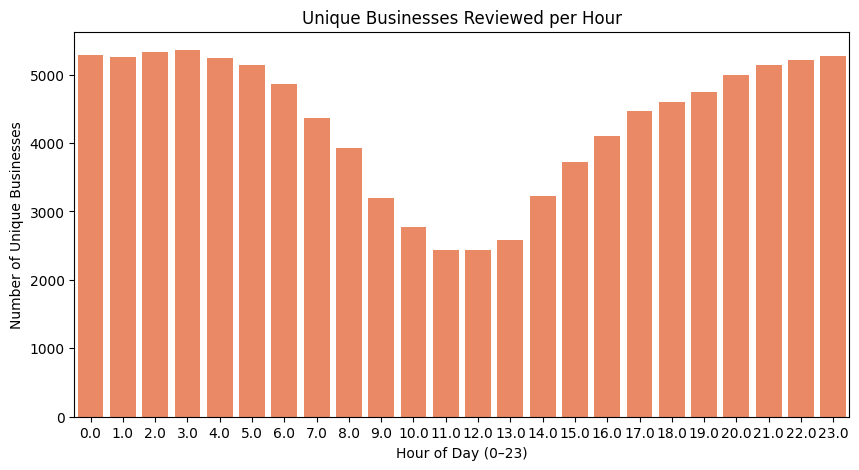

In [68]:
# --- Plot 3: Bar Plot of Unique Businesses Reviewed by Hour ---
unique_biz_by_hour = df_clean.groupby("review_time")["gmap_id"].nunique().reset_index(name="unique_businesses")
plt.figure(figsize=(10,5))
sns.barplot(data=unique_biz_by_hour, x="review_time", y="unique_businesses", color="coral")
plt.title("Unique Businesses Reviewed per Hour")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Unique Businesses")
plt.show();

* On an average, unique businessess reviewed per hour during the peak time is **~5k** and during off-peak hours is **~2.5k**.

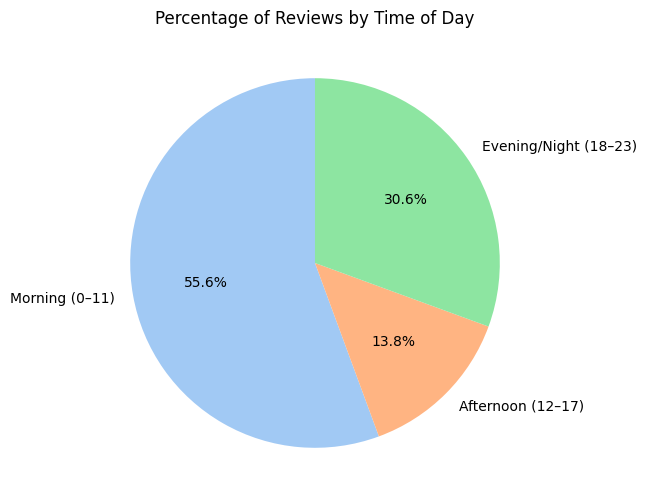

In [69]:
# --- Plot 4: Pie Chart of Reviews by Time of Day ---
time_summary = df_clean.groupby("time_of_day",observed=True)["gmap_id"].count().reset_index(name="num_reviews")
plt.figure(figsize=(6,6))
plt.pie(
    time_summary["num_reviews"],
    labels=time_summary["time_of_day"],
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("pastel")
)
plt.title("Percentage of Reviews by Time of Day")
plt.show();

* From the above pie chart, we can observe that the maximum contribution of the reviews are during morning time i.e., 0-11 hours

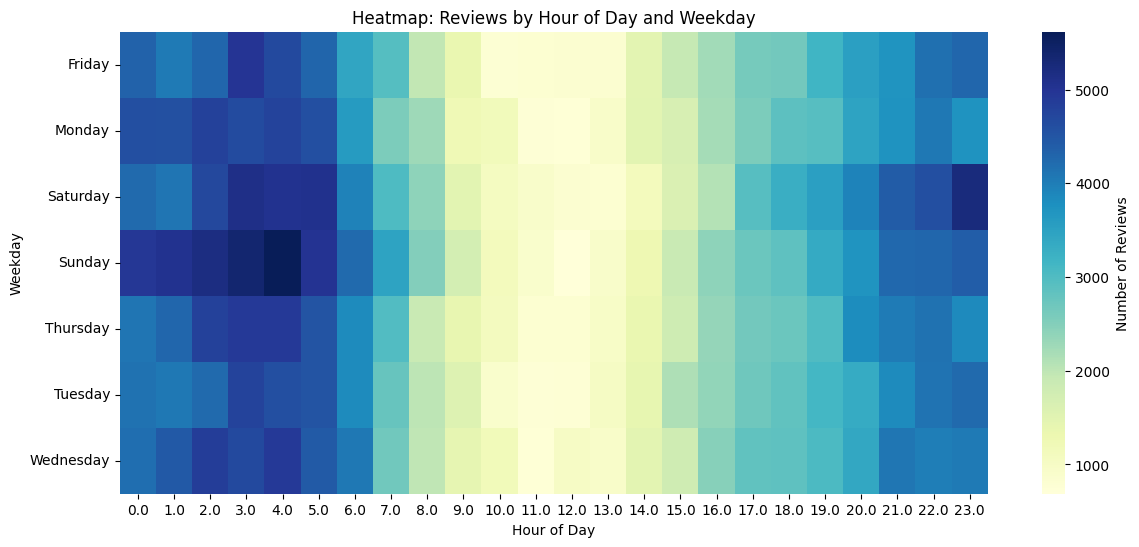

In [70]:
# --- Plot 5: Heatmap of reviews (Hour vs Day of Week) ---
df["weekday"] = pd.to_datetime(df["newtime"]).dt.day_name()

pivot_table = df.pivot_table(index="weekday", columns="review_time", values="gmap_id", aggfunc="count").fillna(0)

plt.figure(figsize=(14,6))
sns.heatmap(pivot_table, cmap="YlGnBu", cbar_kws={'label': 'Number of Reviews'})
plt.title("Heatmap: Reviews by Hour of Day and Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.show()

* The heat map shows that the number of reviews is consistently higher during the mornings and evenings on most days.

* Additionally, we notice a slight increase in reviews over the weekends, particularly on **Saturdays** and **Sundays**."

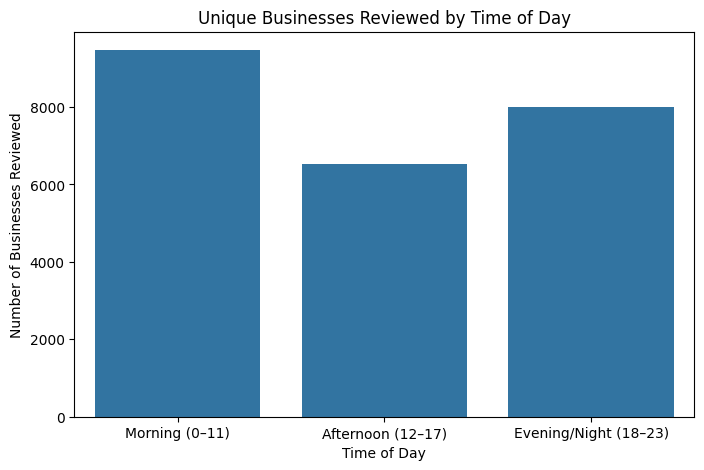

,time_of_day,unique_businesses
0,Morning (0–11),9472
1,Afternoon (12–17),6541
2,Evening/Night (18–23),8010


In [71]:
# --- Plot 6: Morning reviews (0–11 hrs) vs Afternoon/Evening/Night ---
df["time_of_day"] = pd.cut(
    df["review_time"],
    bins=[-1, 11, 17, 23],  # morning=0-11, afternoon=12-17, evening/night=18-23
    labels=["Morning (0–11)", "Afternoon (12–17)", "Evening/Night (18–23)"]
)

time_summary = df.groupby("time_of_day",observed=True)["gmap_id"].nunique().reset_index(name="unique_businesses")

# Plot businesses reviewed by time of day
plt.figure(figsize=(8,5))
sns.barplot(data=time_summary, x="time_of_day", y="unique_businesses")
plt.title("Unique Businesses Reviewed by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Businesses Reviewed")
plt.show();

# Print summary stats
time_summary

* The highest number of reviews are recorded in the **Morning (0–11)**, with **9,472** unique businesses receiving reviews.

* The **Evening/Night (18–23)** also sees significant activity, with **8,010** unique businesses reviewed.
* The **Afternoon (12–17)** period has the lowest number of reviews, with **6,541** unique businesses reviewed."

---
## Question 1.3
---
### Load process data

In [72]:
# Load meta-business data
meta_df = spark.read.csv(f"{extract_dir}/meta-review-business.csv", header=True, inferSchema=True)

# Preview schema
meta_df.printSchema()
meta_df.show(5)

root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- num_of_reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)

+--------------------+--------------------+--------------------+-----------+------------------+-------------------+--------------------+----------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|                name|             address|             gmap_id|description|          latitude|          longitude|         

In [73]:
# Rename columns in meta_df to avoid conflicts
meta_df_clean = (meta_df
                 .withColumnRenamed("name", "business_name"))

# Join with cleaned meta
joined_df = review_df.join(meta_df_clean, on="gmap_id", how="inner")

# Show sample
joined_df.select("gmap_id", "business_name", "category", "rating", "newtime", "review_time").show(5, truncate=False)

+-------------------------------------+---------------------------+------------------------------------------------+------+----------+-----------+
|gmap_id                              |business_name              |category                                        |rating|newtime   |review_time|
+-------------------------------------+---------------------------+------------------------------------------------+------+----------+-----------+
|0x56b646ed2220b77f:0xd8975e316de80952|Bear Creek Cabins & RV Park|['RV park', 'Cabin rental agency', 'Campground']|5     |2019-08-20|20         |
|0x56b646ed2220b77f:0xd8975e316de80952|Bear Creek Cabins & RV Park|['RV park', 'Cabin rental agency', 'Campground']|5     |2019-08-20|20         |
|0x56b646ed2220b77f:0xd8975e316de80952|Bear Creek Cabins & RV Park|['RV park', 'Cabin rental agency', 'Campground']|5     |2017-09-09|0          |
|0x56b646ed2220b77f:0xd8975e316de80952|Bear Creek Cabins & RV Park|['RV park', 'Cabin rental agency', 'Campground']|5 

#### Answer 1.3.1

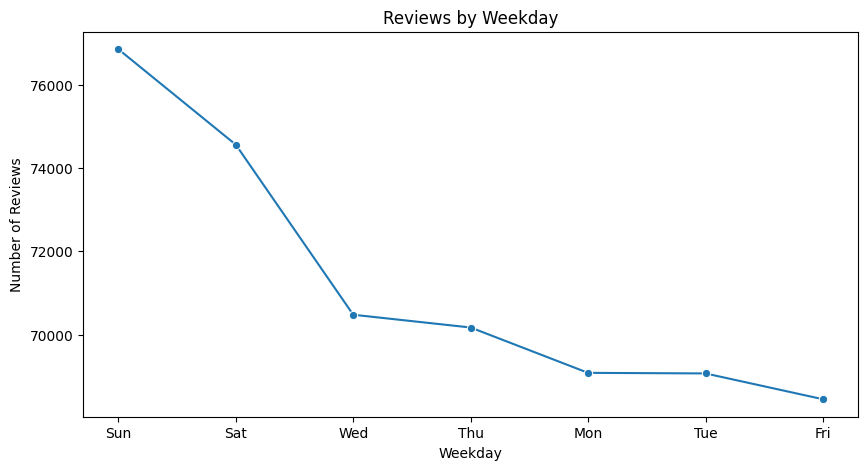



The weekday with most reviews is: Sun


In [74]:
from pyspark.sql.functions import date_format

# Extract weekday name
weekday_df = joined_df.withColumn("weekday", date_format("newtime", "E"))  # e.g., Mon, Tue

# Count reviews by weekday
reviews_by_weekday = weekday_df.groupBy("weekday").count().orderBy("count", ascending=False)

# Convert to Pandas for plotting
reviews_weekday_pd = reviews_by_weekday.toPandas()

# Plot
plt.figure(figsize=(10,5))
sns.lineplot(data=reviews_weekday_pd, x="weekday", y="count", marker="o", sort=False)
plt.title("Reviews by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Reviews")
plt.show();

# Most active weekday
most_active_day = reviews_weekday_pd.loc[reviews_weekday_pd["count"].idxmax(), "weekday"]
print("\n\nThe weekday with most reviews is:", most_active_day)

### Answer 1.3.2

In [75]:
# Filter reviews only from the most active weekday
weekday_filtered = weekday_df.filter(col("weekday") == most_active_day)

# Find businesses with highest avg rating
top_businesses = (weekday_filtered.groupBy("name", "category")
                  .agg(avg("rating").alias("avg_rating"))
                  .orderBy("avg_rating", ascending=False)
                  .limit(10))

top_businesses.show(truncate=False)

+-------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|name                     |category                                                                                                                                                           |avg_rating|
+-------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|Michael Cleveland        |['Cannabis store']                                                                                                                                                 |5.0       |
|Michael Hanna            |['Western apparel store', 'Boot store', 'Clothing store', 'Hat shop', 'Tack shop']                                                                               

### Answer 1.3.3

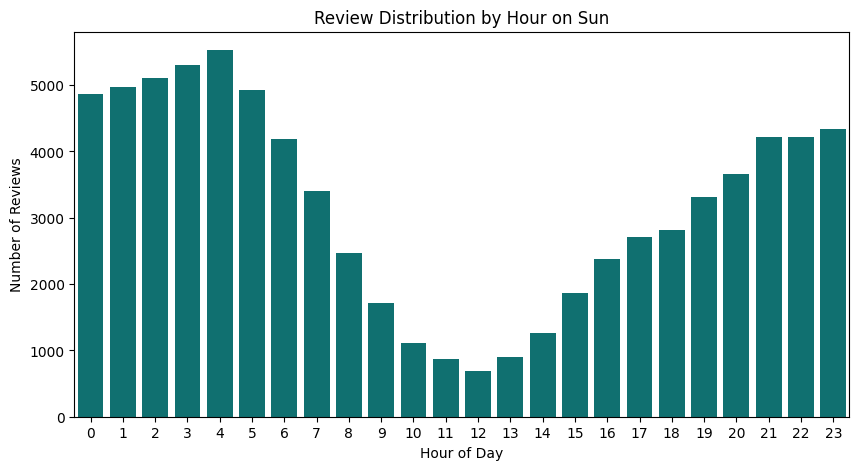

In [76]:
# Reviews per hour on the most active weekday
weekday_hours = (weekday_filtered.groupBy("review_time")
                 .count()
                 .orderBy("review_time"))

weekday_hours_pd = weekday_hours.toPandas()

plt.figure(figsize=(10,5))
sns.barplot(data=weekday_hours_pd, x="review_time", y="count", color="teal")
plt.title(f"Review Distribution by Hour on {most_active_day}")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Reviews")
plt.show();

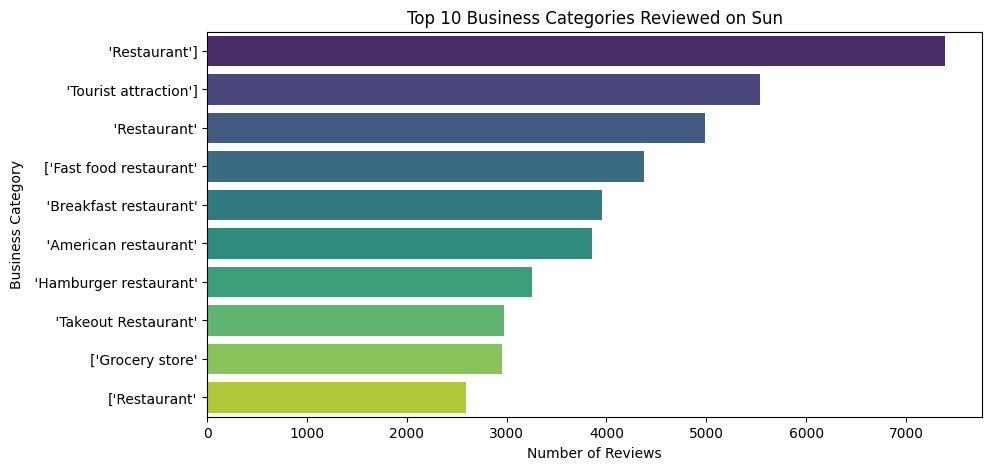

In [77]:
# Explode categories (if multiple categories separated by ';' or ',')
from pyspark.sql.functions import split, explode

exploded = weekday_filtered.withColumn("category", explode(split(col("category"), ",")))

top_categories = (exploded.groupBy("category")
                  .count()
                  .orderBy("count", ascending=False)
                  .limit(10))

top_categories_pd = top_categories.toPandas()

plt.figure(figsize=(10,5))
sns.barplot(data=top_categories_pd, x="count", y="category", palette="viridis", hue = "category")
plt.title(f"Top 10 Business Categories Reviewed on {most_active_day}")
plt.xlabel("Number of Reviews")
plt.ylabel("Business Category")
plt.show();

### Insights

- The most reviewed categories on **Sunday** are strongly dominated by **restaurants** of various types.  
- `'Restaurant'`, `'Fast food restaurant'`, `'Breakfast restaurant'`, `'American restaurant'`, and `'Hamburger restaurant'` appear multiple times in the top 10 list.  
- `'Tourist attraction'` also ranks very high, showing that Sundays are popular days for leisure activities.  
- Retail-related categories like `'Grocery store'` also appear but have significantly fewer reviews compared to dining and leisure.  
- **Peak review hours on Sunday** are between **0–6 AM** (likely from late-night/early-morning activities) and **7–11 PM**, suggesting reviews are often written right after social or dining experiences.

**Conclusion:**  
Sundays attract the **highest review activity**, with the **food & dining sector** being the most prominent. Customers review most frequently during **late night/early morning** and **evening hours**, reflecting weekend leisure and dining habits.